# "Monte Carlo Methods for learning the state-value function in Reinforcement Learning for a given Policy"

> Monte Carlo Prediction for Policy Evaluation
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/MC Prediction.png
- categories: [Reinforcement_Learning,MC,  OpenAI,Gym,]
- show_tags: true

In [1]:
# hide
# inspired by MC Prediction Solution_ANNO.ipynb

In [2]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Sutton&Barto/ch05/dennybritz_reinforcement-learning_MC/'

Mounted at /content/gdrive


In [3]:
# hide
%cd "{base_dir}"

/content/gdrive/My Drive/Sutton&Barto/ch05/dennybritz_reinforcement-learning_MC


In [4]:
# hide
!pwd

/content/gdrive/My Drive/Sutton&Barto/ch05/dennybritz_reinforcement-learning_MC


## 1. Introduction

In a *Markov Decision Process* (Figure 1) the *agent* and *environment* interacts continuously.

![Figure 1  Agent/Environment interaction in a MDP](../images/mc-prediction_agent-environment_fig1.png "Figure 1  Agent/Environment interaction in a MDP")

More details are available in [Reinforcement Learning: An Introduction by Sutton and Barto](http://incompleteideas.net/book/RLbook2020.pdf).

The dynamics of the MDP is given by
$$ 
\begin{aligned}
p(s',r|s,a) &= Pr\{ S_{t+1}=s',R_{t+1}=r | S_t=s,A_t=a \} \\
\end{aligned}
$$

The *policy* of an agent is a mapping from the current state of the environment to an *action* that the agent needs to take in this state. Formally, a policy is given by
$$ 
\begin{aligned}
\pi(a|s) &= Pr\{A_t=a|S_t=s\}
\end{aligned}
$$

The discounted *return* is given by
$$ 
\begin{aligned}
G_t &= R_{t+1} + \gamma R_{t+2} + \gamma ^2 R_{t+3} + ... + R_T \\
    &= \sum_{k=0}^\infty \gamma ^k R_{t+1+k}
\end{aligned}
$$
where $\gamma$ is the discount factor and $R$ is the *reward*.

Most reinforcement learning algorithms involve the estimation of value functions - in our present case, the *state-value function*. The state-value function maps each state to a measure of "how good it is to be in that state" in terms of expected rewards. Formally, the state-value function, under policy $\pi$ is given by
$$ 
\begin{aligned}
v_\pi(s) &= \mathbb{E}_\pi[G_t|S_t=s]
\end{aligned}
$$

The Monte Carlo algorithm discussed in this post will numerically estimate $v_\pi(s)$.

## 2. Environment

The environment is the game of *Blackjack*. The player tries to get cards whose sum is as great as possible without exceeding 21. Face cards count as 10. An ace can be taken either as a 1 or an 11. Two cards are dealth to both dealer and player. One of the dealer's cards is face up (other is face down). The player can request additional cards, one by one (called *hits*) until the player stops (called *sticks*) or goes above 21 (goes *bust* and loses). When the players sticks it becomes the dealer's turn which uses a fixed strategy: sticks when the sum is 17 or greater and hits otherwise. If the dealer goes bust the player wins, otherwise the winner is determined by whose sum is closer to 21.

We formulate this game as an episodic finite MDP. Each game is an episode. 

* States are based on the player's
  * current sum (12-21)
  * dealer's face up card (ace-10)
  * whether player holds usable ace (True or False)

This gives a total of 200 states: $10 × 10 \times 2 = 200$

* Rewards are for
  * winning (+1)
  * losing (-1)
  * drawing (0)

The environment is implemented using the OpenAI Gym library.

## 3. Agent

The *agent* is the player. After observing the state of the *environment*, the agent can take one of two possible actions:

* stick (0) [stop receiving cards]
* hit (1) [have another card]

The agent's policy will be deterministic - will always stick of the sum is 20 or 21, and hit otherwise. We call this *policy1* in the code.

## 4. Monte Carlo Prediction

We will now proceed to learn the state-value function for the given policy $\pi$. We can take $\gamma=1$ as the sum will remain finite:

$$ 
\begin{aligned}
v_\pi(s) &= \mathbb{E}_\pi[G_t | S_t=s] \\
         &= \mathbb{E}_\pi[R_{t+1} + \gamma R_{t+2} + \gamma ^2 R_{t+3} + ... + R_T | S_t=s] \\
         &= \mathbb{E}_\pi[R_{t+1} + R_{t+2} + R_{t+3} + ... + R_T | S_t=s]
\end{aligned}
$$

In numeric terms this means that, given a state, we take the sum of all rewards from that state onwards until the game ends, and take the average of all such sequences.


## 5. Implementation

Next, we present the code that implements the algorithm.

In [5]:
import gym
import matplotlib
import numpy as np
import sys
from collections import defaultdict
import pprint as pp
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
# hide
from lib import plotting as myplot
from lib.envs.blackjack import BlackjackEnv

In [7]:
# hide
# env = gym.make('Blackjack-v0')#.has differences cp to the one used here
#- env = gym.make('Blackjack-v1')#.does not exist

In [8]:
env = BlackjackEnv()

In [9]:
# hide
# handy to experiment before saving this function to plotting.py
# import matplotlib
# from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# def plot_value_function(V, title="Value Function", wireframe=True):
#     """
#     Plots the value function as a surface plot.
#     """
#     min_x = min(k[0] for k in V.keys())
#     max_x = max(k[0] for k in V.keys())
#     min_y = min(k[1] for k in V.keys())
#     max_y = max(k[1] for k in V.keys())

#     x_range = np.arange(min_x, max_x + 1)
#     y_range = np.arange(min_y, max_y + 1)
#     X, Y = np.meshgrid(x_range, y_range)

#     # Find value for all (x, y) coordinates
#     Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
#     Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

#     def plot_surface(X, Y, Z, title, wireframe):
#         fig = plt.figure(figsize=(20, 10))
#         ax = fig.add_subplot(111, projection='3d')
#         if wireframe:
#           surf = ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1) #.
#         else:
#           surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
#                                 cmap=matplotlib.cm.BrBG,
#                                 vmin=-1.0, vmax=1.0)
#           fig.colorbar(surf)  
#         ax.set_xlabel('Player sum')
#         ax.set_ylabel('Dealer showing')
#         ax.set_zlabel('Value')
#         ax.set_title(title)
#         # ax.view_init(ax.elev, -120)#.
#         ax.view_init(ax.elev + 10, -160)
#         plt.show()
#     plot_surface(X, Y, Z_ace, "{} (Usable ace)".format(title), wireframe)
#     plot_surface(X, Y, Z_noace, "{} (No usable ace)".format(title), wireframe)

### 5.1 Policy

The following function captures the policy used by the agent:

In [10]:
def policy1(observation):
    player_sum, dealer_showing, usable_ace = observation
    if player_sum >=20:
      return 0 #stick
    else:
      return 1 #hit

### 5.2 Generate episodes

The following function sets the environment to a random initial state. It then enters a loop that each iteration applies the policy to the environment's state to obtain the next action to be taken by the agent. That action is then applied to the environment to get the next state, and so on until the episode ends.

In [11]:
def generate_episode(env, policy):
  episode = []
  state = env.reset()
  while True:
      action = policy(state)
      next_state, reward, done, _ = env.step(action) # St+1, Rt+1 OR s',r
      episode.append((state, action, reward)) # St, At, Rt+1 OR s,a,r
      # state = next_state #.
      if done:
          if diag: print('\nepisode:', episode)#.
          break
      state = next_state
  return episode

### 5.3 Main loop

The following function implements the main loop of the algorithm. It iterates for ``num_episodes``. It also takes a list ``monitored_states`` for which it will record the evolution of state values. This is handy for showing how state values converge during the process.

In [12]:
diag = False #diagnostics flag
def mc_prediction(policy, env, num_episodes, discount_factor=1.0, monitored_states=None):
    G_sum = defaultdict(float)
    G_count = defaultdict(float)
    V = defaultdict(float) #final value function
    monitored_state_values = defaultdict(list)
    for i in range(1, num_episodes + 1):
        if i%1000 == 0:
            print("\rEpisode {}/{}".format(i, num_episodes), end=""); sys.stdout.flush()
        episode = generate_episode(env, policy)
        #Find all visited states in this episode
        episode_states = set([tuple(sar[0]) for sar in episode]) #put state in tuple and use as key
        if diag: print('episode_states:', episode_states)
        for state in episode_states:
            #--find the first visit to the state in the episode
            first_visit_ix = next(i for i,sar in enumerate(episode) if sar[0] == state)
            if diag: print(f'---state {state} first_visit_ix: {first_visit_ix}')
            #--sum up all rewards since the first visit
            if diag: print('episode[first_visit_ix:]:', episode[first_visit_ix:])
            # print('episode[first_visit_ix + 1:]:', episode[first_visit_ix + 1:]) #NO - each r is the next reward Rt+1=r
            if diag: print('rewards:', [sar[2]*(discount_factor**i) for i,sar in enumerate(episode[first_visit_ix:])])
            G = sum([sar[2]*(discount_factor**i) for i,sar in enumerate(episode[first_visit_ix:])])
            if diag: print('G:', G)
            #--calculate average return for this state over all sampled episodes
            G_sum[state] += G
            G_count[state] += 1.0
            V[state] = G_sum[state]/G_count[state]
        if monitored_states:
          for ms in monitored_states: 
            # print("\rV[{}]: {}".format(ms, V[ms]), end=""); sys.stdout.flush()
            monitored_state_values[ms].append(V[ms])
    if diag: print('\n++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    if diag: pp.pprint(f'G_sum: {G_sum}')
    if diag: pp.pprint(f'G_count: {G_count}')
    if diag: print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    # print('\nmonitored_state_values:', monitored_state_values)
    return V,monitored_state_values

In [13]:
# hide
# debug
discount_factor = 1.0
episode = [((10, 10, True), 1, 0), ((16, 10, True), 1, 0), ((12, 10, True), 1, 0), ((16, 10, True), 1, 0), ((15, 10, False), 1, -1)]; print('episode:', episode)
states_in_episode = {(16, 10, True), (15, 10, False), (12, 10, True)}
state = (16, 10, True); print('state:', state)
first_visit_idx = next(i for i,sar in enumerate(episode) if sar[0] == state); print('first_visit_idx:', first_visit_idx)
print('episode[first_visit_idx:]:', episode[first_visit_idx:])
# print('episode[first_visit_idx + 1:]:', episode[first_visit_idx + 1:]) #NO - each r is the next reward Rt+1=r
print('rewards:', [sar[2]*(discount_factor**i) for i,sar in enumerate(episode[first_visit_idx:])])
G = sum([sar[2]*(discount_factor**i) for i,sar in enumerate(episode[first_visit_idx:])]); print('G:', G)

episode: [((10, 10, True), 1, 0), ((16, 10, True), 1, 0), ((12, 10, True), 1, 0), ((16, 10, True), 1, 0), ((15, 10, False), 1, -1)]
state: (16, 10, True)
first_visit_idx: 1
episode[first_visit_idx:]: [((16, 10, True), 1, 0), ((12, 10, True), 1, 0), ((16, 10, True), 1, 0), ((15, 10, False), 1, -1)]
rewards: [0.0, 0.0, 0.0, -1.0]
G: -1.0


In [14]:
# hide
# for debug
# monitored_state=(12, 7, False)
# V_50,monitored_state_values = mc_prediction(policy1, env, num_episodes=50, monitored_state=monitored_state)

### 5.4 Monitored states

Let's pick a number of states to monitor. Each tuple captures the player's sum, the dealer's showing card, and whether the player has a usable ace:

In [15]:
monitored_states=[(21, 7, False), (20, 7, True), (12, 7, False), (17, 7, True)]

### 5.5 Run 1

First, we will run the algorithm for 10,000 episodes, using policy1:

In [39]:
V_10_000,monitored_state_values = mc_prediction(policy1, env, num_episodes=10_000, monitored_states=monitored_states)
# V_10_000,monitored_state_values = mc_prediction(policy1, env, num_episodes=10_000, monitored_states=None)

Episode 10000/10000

The following chart shows how the values of the 4 monitored states converge to their values:

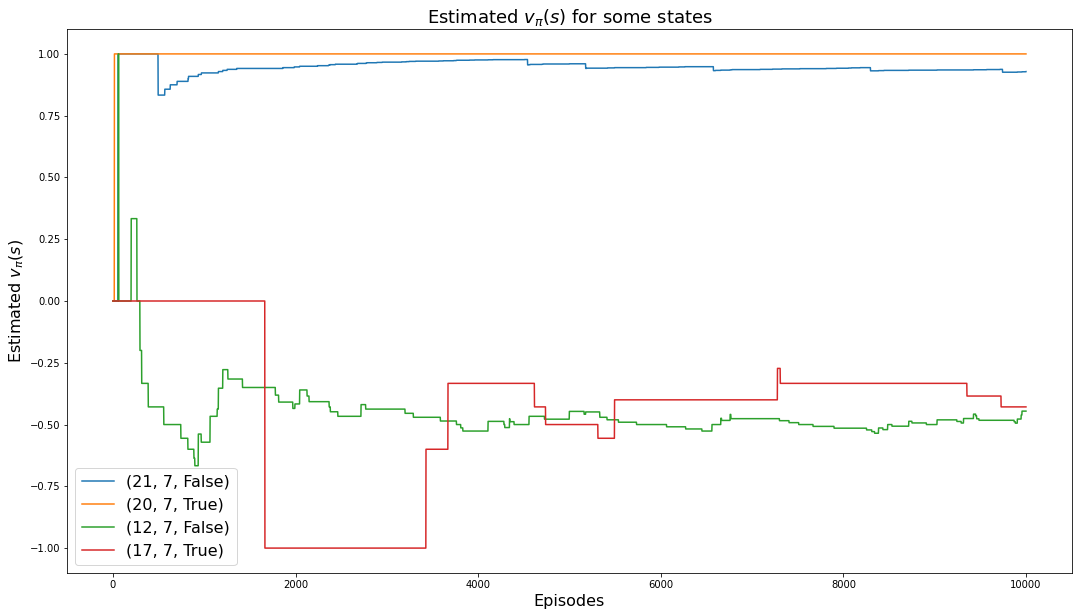

In [40]:
plt.rcParams["figure.figsize"] = (18,10)
for ms in monitored_states:
  plt.plot(monitored_state_values[ms])
plt.title('Estimated $v_\pi(s)$ for some states', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Estimated $v_\pi(s)$', fontsize=16)
plt.legend(monitored_states, fontsize=16)
plt.show()

In [28]:
# hide
monitored_state_values[monitored_states[0]][-1], V_10_000[monitored_states[0]]

(0.9230769230769231, 0.9230769230769231)

The following wireframe charts shows the estimate of the state-value function, $v_\pi(s)$, for the cases of a usable ace as well as not a usable ace:

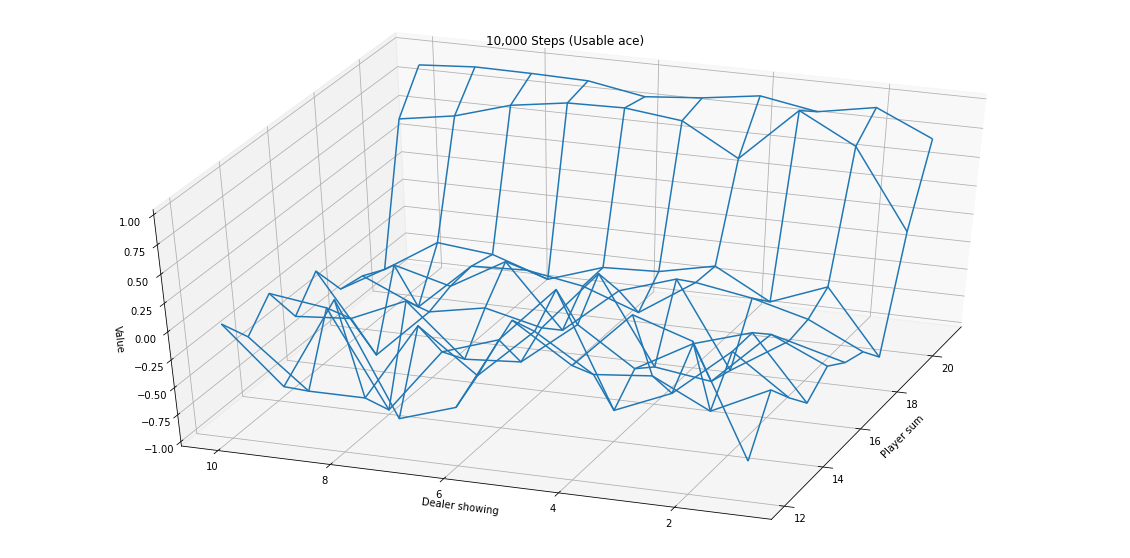

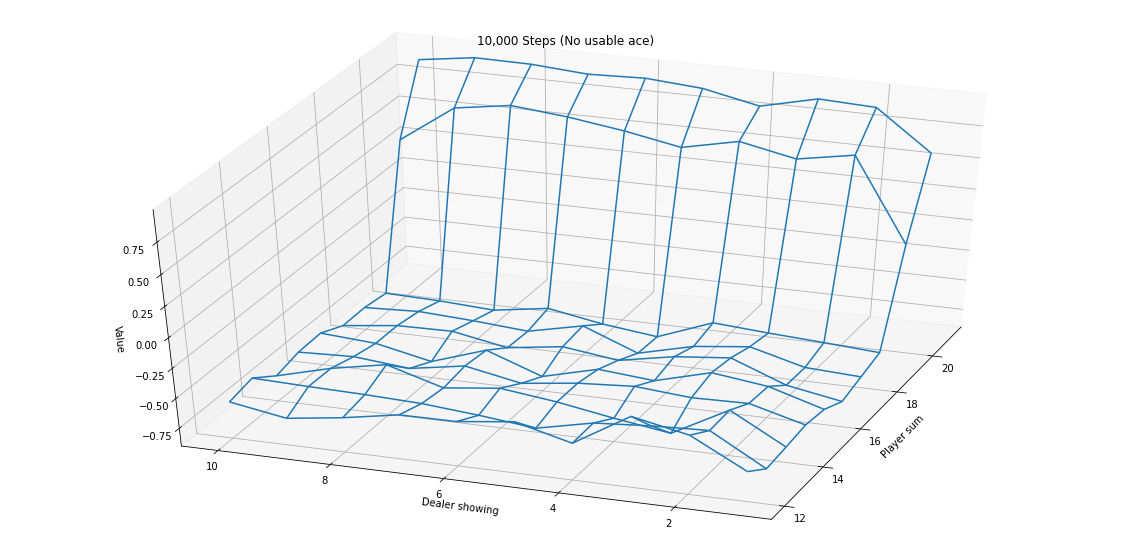

In [29]:
myplot.plot_state_value_function(V_10_000, title="10,000 Steps", wireframe=True)

Here are the same charts but with coloration: 

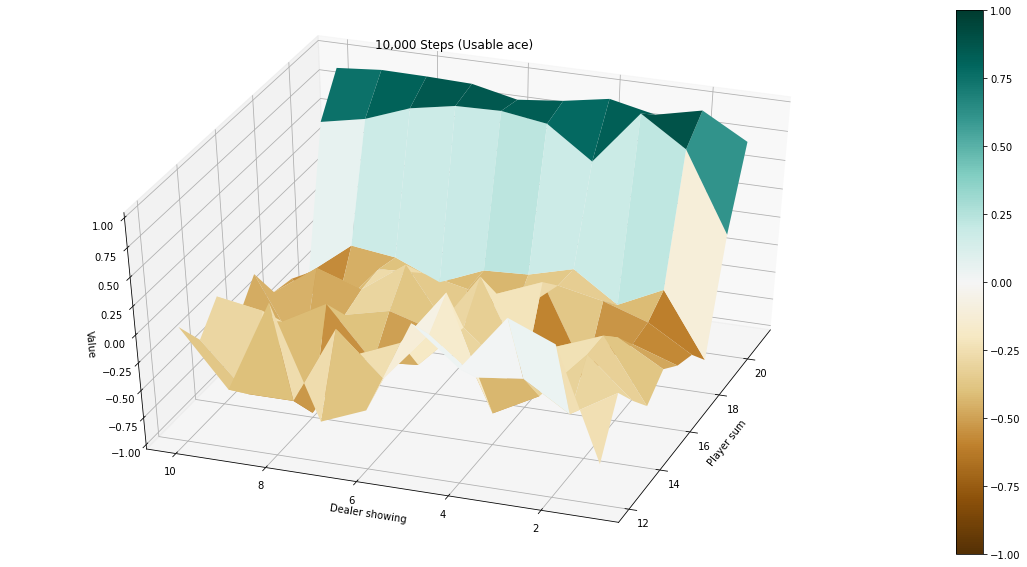

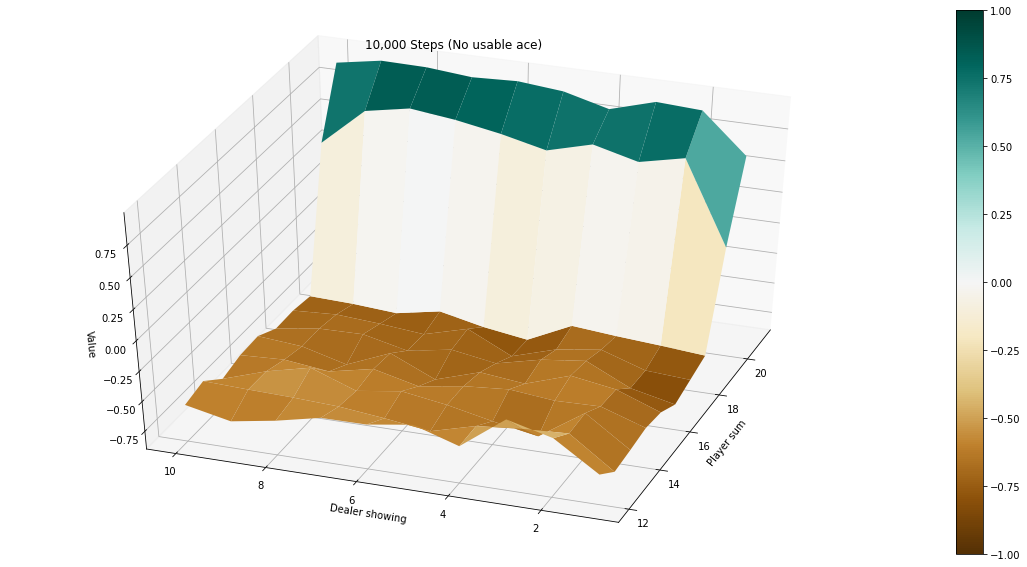

In [30]:
myplot.plot_state_value_function(V_10_000, title="10,000 Steps", wireframe=False)

### 5.6 Run 2

Our final run uses 500,000 episodes and the accuracy of the state-value function is higher.

In [31]:
# hide
# monitored_states[:4]

In [32]:
V_500_000,monitored_state_values = mc_prediction(policy1, env, num_episodes=500_000, monitored_states=monitored_states)
# V_500_000,monitored_state_values = mc_prediction(policy1, env, num_episodes=500_000, monitored_states=None)
# V_1_000_000,monitored_state_values = mc_prediction(policy1, env, num_episodes=1_000_000, monitored_states=monitored_states)

Episode 500000/500000

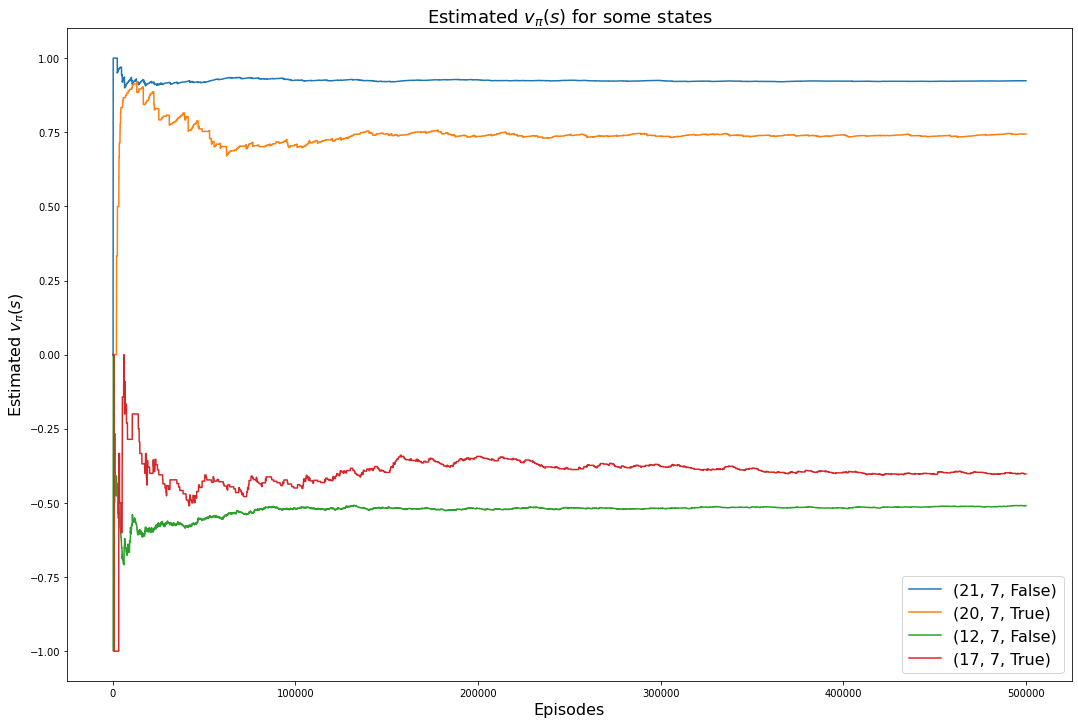

In [34]:
plt.rcParams["figure.figsize"] = (18,12)
for ms in monitored_states:
  plt.plot(monitored_state_values[ms])
plt.title('Estimated $v_\pi(s)$ for some states', fontsize=18)
plt.xlabel('Episodes', fontsize=16)
plt.ylabel('Estimated $v_\pi(s)$', fontsize=16)
plt.legend(monitored_states, fontsize=16)
plt.show()

In [35]:
# hide
monitored_state_values[monitored_states[0]][-1], V_500_000[monitored_states[0]]

(0.9235966735966736, 0.9235966735966736)

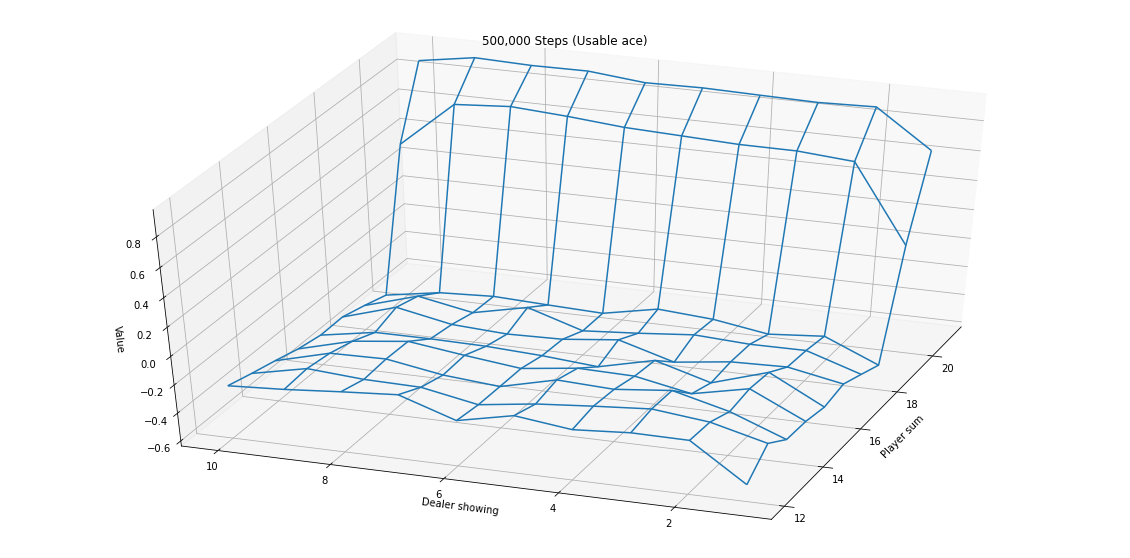

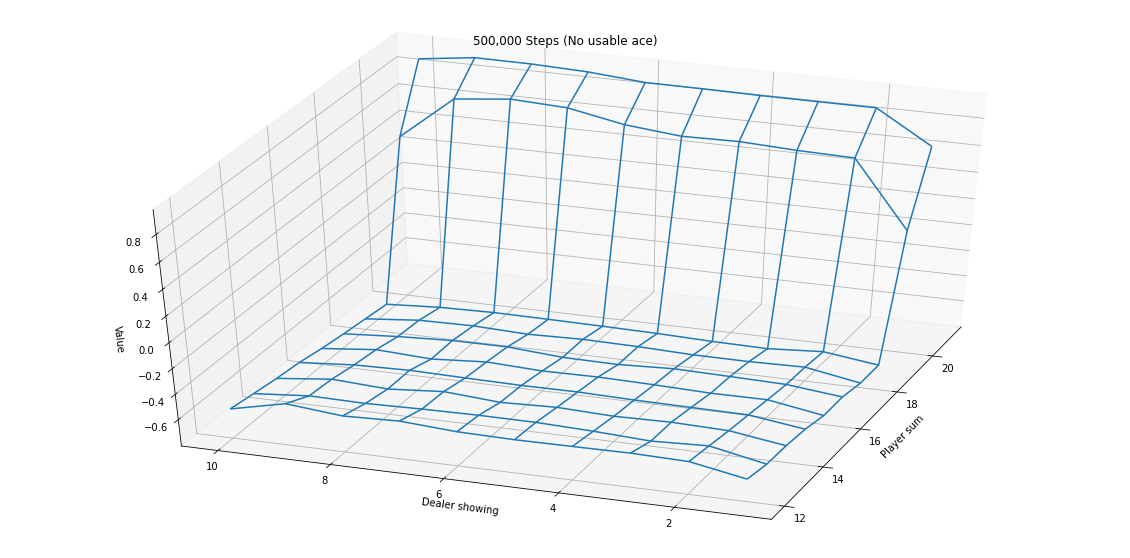

In [36]:
# myplot.plot_state_value_function(V_500_000, title="500,000 Steps")
myplot.plot_state_value_function(V_500_000, title="500,000 Steps", wireframe=True)
# myplot.plot_state_value_function(V_1_000_000, title="1,000,000 Steps")

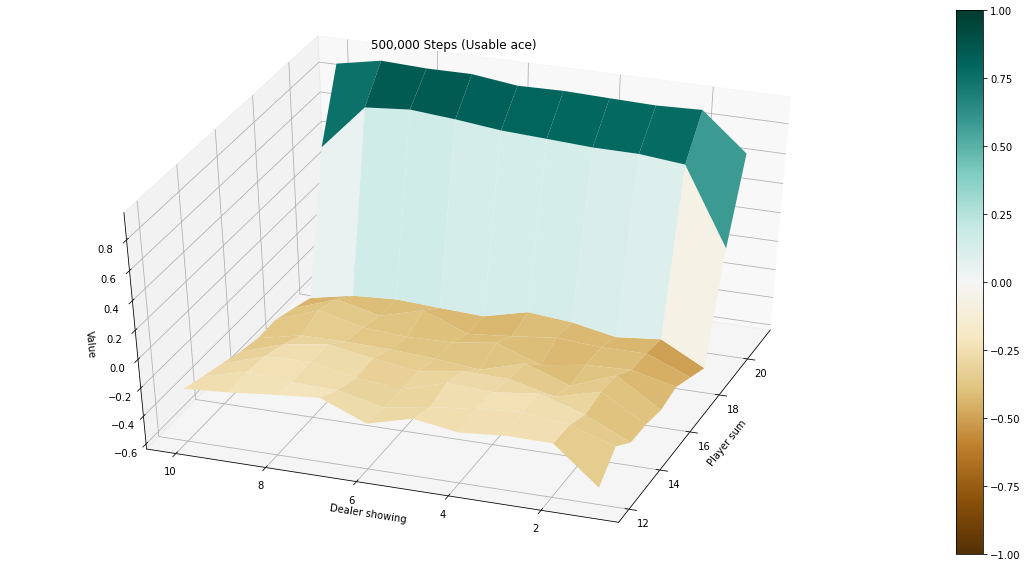

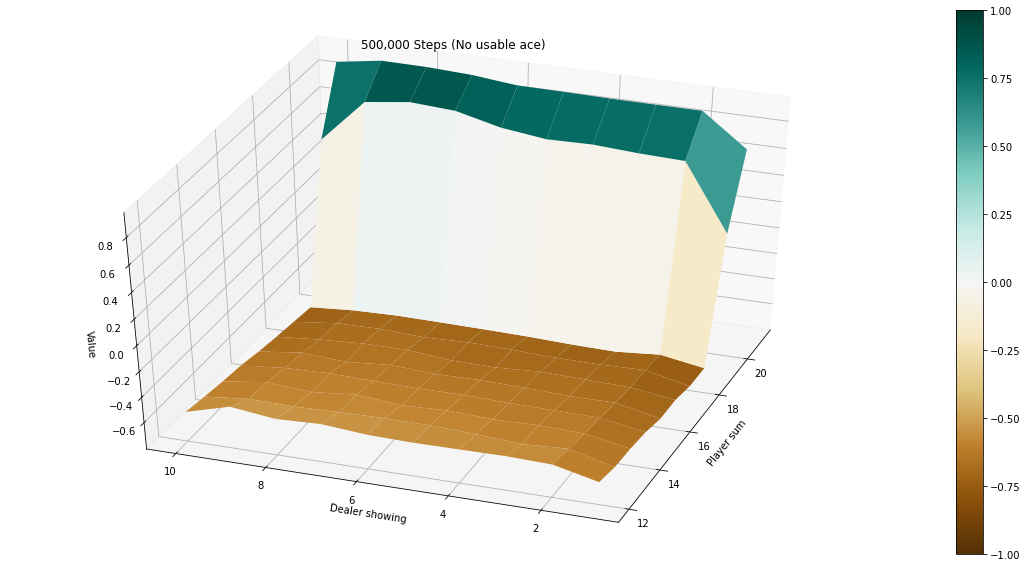

In [37]:
myplot.plot_state_value_function(V_500_000, title="500,000 Steps", wireframe=False)